# 감성 분석

## 0) Import

In [6]:
# !pip install tensorflow
# !pip install konlpy

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Komoran

## 1) 데이터 불러오기

In [12]:
df = pd.read_csv("./총데이터.csv")
# df.shape

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1, random_state=42)
print('훈련용 리뷰의 개수 :', len(train))
print('테스트용 리뷰의 개수 :', len(test))

훈련용 리뷰의 개수 : 196587
테스트용 리뷰의 개수 : 21843


In [14]:
train.head()

,id,document,label
55108,5739157,그냥저냥 볼만한데..,1
177778,10184580,별점이 높을만 하다! 스포츠 관련 영화는 안보는데 끌려서 봤더니.. 내 감 아직 안...,1
208420,5379874,재밋다 ㅋ,1
39144,4774633,"갠찬았는데.. 어떻게보면 싸이코같지만, 많은생각을갖게만드는 영화",1
55080,8336803,전체적인 구성은 좋았지만 세밀한 디테일이 좀 부족한 영화,1


In [7]:
test.head()

,id,document,label
50798,4870266,지켜야 할 전통과 버려야 할 악습을 구분하라는 좋은 주제만이...,0
166003,3397622,그때로 돌아가고 있다.. 이 영화 1급공무원이 봤으면 한다.,1
123822,9735801,그냥 뮤지컬이라고 생각하고 음악에 몰입하면 한없이 즐거운 영화,1
31635,10246552,재밌게 잘 봤습니다 상영 후 시네마토크와 gv를 통해 영화에 대한 더 깊은 이해를 ...,1
21160,6800636,보라연기진짜못하던데그거때문에영화에집중도안되고ㅡㅡ,0


In [20]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (196587, 3) 
test shape => (21843, 3)


In [21]:
train.columns

Index(['id', 'document', 'label'], dtype='object')

In [28]:
# #  문자열 아닌 데이터 모두 제거
# train = [review for review in train['document'] if type(review) is str]
# test = [review for review in test['document'] if type(review) is str]

## 2) 훈련 데이터 라벨링 값 비율 확인

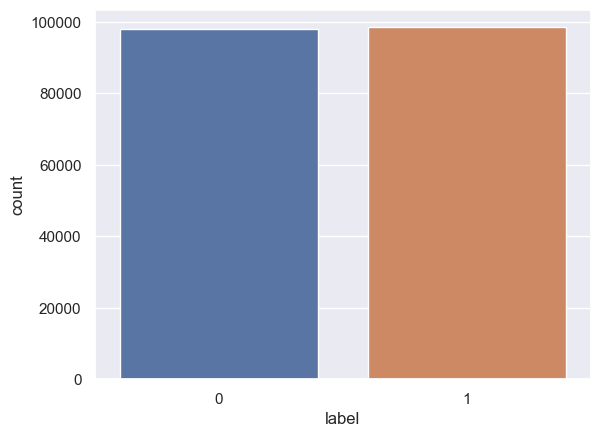

In [22]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

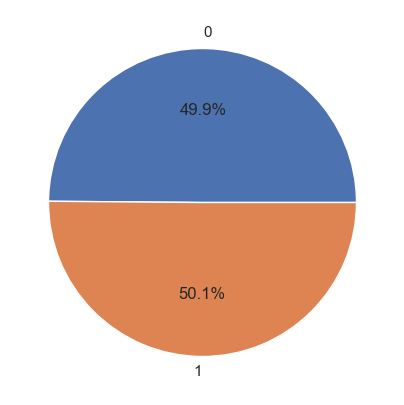

In [11]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3) 훈련, 테스트 데이터 결측치 값 확인

In [12]:
train.isnull().sum()

id          12734
document        7
label           0
dtype: int64

In [13]:
test.isnull().sum()

id          1400
document       1
label          0
dtype: int64

## 4) 데이터 전처리
- 데이터 중복제거(drop_duplicates)  
- 결측치 제거(dropna)  
- 한국어 토크나이저를 활용한 토큰화(Komoran)  
- 불용어 제거(조사,구두점,접미사 종류)
- Bag of Words, word to index, index to word 구현  
- 문장 길이 분포와 적절 최대 문자 길이 지정  
- 최대 문자 길이에 따른 패딩 추가(pad_sequences)

In [15]:
import os

In [11]:
# os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-20\bin\server'

In [24]:
tokenizer = Komoran()

def preprocess(train, test):
    train.drop_duplicates(subset=['document'], inplace=True)
    test.drop_duplicates(subset=['document'], inplace=True)
    train = train.dropna()
    test = test.dropna()
    print(f"train shape => {train.shape} \ntest shape => {test.shape}")
    
    train_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train['document']]
    test_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test['document']]
    
    exclusion_tags = ['영화', '10점', '0점']
    
    f = lambda x: x in exclusion_tags
    
    X_train = []
    for i in range(len(train_tokenized)):
        temp = []
        for j in range(len(train_tokenized[i])):
            if f(train_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_tokenized[i][j].split('/')[0])
        X_train.append(temp)
    
    X_test = []
    for i in range(len(test_tokenized)):
        temp = []
        for j in range(len(test_tokenized[i])):
            if f(test_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_tokenized[i][j].split('/')[0])
        X_test.append(temp)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(30000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train['label'])), X_test, np.array(list(test['label'])), word_to_index

In [28]:
# print(word_to_index)

In [30]:
# DATA_CONFIGS = './data2/LSTM/data_configs.json'
# json.dump(data_configs,open('./data2/LSTM/word_to_index.json'))

In [31]:
# data_configs={}
# data_configs['vocab'] = word_to_index
# data_configs['vocab_size'] = len(word_to_index) +1

In [32]:
# # print(data_configs)
# #데이터사전 json으로 저장
# json.dump(data_configs, open(DATA_CONFIGS,'w'), ensure_ascii=False)

In [35]:
X_train, y_train, X_test, y_test, word_to_index = preprocess(train, test)

train shape => (178920, 3) 
test shape => (20175, 3)


In [36]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [37]:
all_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in all_data]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 20.086717396217885
토큰 길이 최대: 2212
토큰 길이 표준편차: 19.97320662206737
설정 최대 길이: 60
전체 문장의 0.9503201989000226%가 설정값인 60에 포함됩니다.


### max_len = 60 이 아닌 임의 값을 정해 진행했습니다.

In [38]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=70)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=70)

In [39]:
print(f"X_train 1번째 값 길이 : {len(X_train[0])}\nX_test 1번째 값 길이 : {len(X_test[0])}")

X_train 1번째 값 길이 : 70
X_test 1번째 값 길이 : 70


## 5) 모델링 - LSTM

In [40]:
vocab_size = 30000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          480000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 480,809
Trainable params: 480,809
Non-trainable params: 0
_________________________________________________________________


In [42]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True,
                                                  stratify=y_train, random_state=777)

In [43]:
history = model.fit(X_train, y_train, epochs=10, batch_size=512,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
315/315 [==============================] - 14s 35ms/step - loss: 0.5036 - accuracy: 0.7636 - val_loss: 0.3951 - val_accuracy: 0.8299
Epoch 2/10
315/315 [==============================] - 11s 35ms/step - loss: 0.3594 - accuracy: 0.8485 - val_loss: 0.3674 - val_accuracy: 0.8388
Epoch 3/10
315/315 [==============================] - 11s 34ms/step - loss: 0.3273 - accuracy: 0.8636 - val_loss: 0.3628 - val_accuracy: 0.8419
Epoch 4/10
315/315 [==============================] - 11s 34ms/step - loss: 0.3070 - accuracy: 0.8729 - val_loss: 0.3628 - val_accuracy: 0.8422
Epoch 5/10
315/315 [==============================] - 11s 34ms/step - loss: 0.2913 - accuracy: 0.8803 - val_loss: 0.3703 - val_accuracy: 0.8401
Epoch 6/10
315/315 [==============================] - 11s 35ms/step - loss: 0.2779 - accuracy: 0.8867 - val_loss: 0.3712 - val_accuracy: 0.8404
Epoch 7/10
315/315 [==============================] - 11s 35ms/step - loss: 0.2647 - accuracy: 0.8926 - val_loss: 0.3796 - val_accuracy:

In [44]:
# 모델 저장하기
from tensorflow.keras.models import save_model
save_model(model,'./data2/LSTM/')

INFO:tensorflow:Assets written to: ./data2/LSTM/assets


INFO:tensorflow:Assets written to: ./data2/LSTM/assets


In [45]:
# 6. 모델 저장하기
from keras.models import load_model
save_model(model,'./data2/LSTM/model.h5')
# model.save('./data2/LSTM/model.h5')

In [46]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

631/631 [==============================] - 3s 5ms/step - loss: 0.4187 - accuracy: 0.8375
[0.4186963140964508, 0.8375216722488403]


In [47]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [49]:
# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# plt.plot(epochs, loss, 'r', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [50]:
# !pip install requests
# !pip install numpy
# !pip install prometheus_api_client
# !pip install scikit-learn
# !pip install matplotlib
# !pip install pyupbit 
# !pip install pydot
# from keras.models import load_model

In [53]:
import numpy as np
import pandas as pd
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import requests
import json

In [106]:
import requests 
def get_stt():
    url_speech = 'http://172.30.1.111:8000/api/speech/'

    response = requests.get(url_speech)
    if response.status_code == 200:
        data = response.json()
        print("API GET 요청 성공")
        return data[0]['text']
    else:
        print("API GET 요청 실패:", response.status_code)
        return None
    
text_data = get_stt()

print(text_data)

API GET 요청 성공
우리 모두 힘내요


In [107]:
okt = Okt()
tokenizer  = Tokenizer()

# DATA_CONFIGS = 'C:\Users\Administrator\Downloads\Window23-main\AI\data\data\content\sample_data\CLEAN_DATA\data_configs.json'
DATA_CONFIGS = './data2/LSTM/data_configs.json'
prepro_configs = json.load(open(DATA_CONFIGS,'r'))
word_vocab =prepro_configs['vocab']

tokenizer.fit_on_texts(word_vocab)

MAX_LENGTH = 30 #문장최대길이

sentence = text_data
sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\\s ]','', sentence)
stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한'] # 불용어 추가할 것이 있으면 이곳에 추가
sentence = okt.morphs(sentence, stem=True) # 토큰화
sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
vector  = tokenizer.texts_to_sequences(sentence)
pad_new = pad_sequences(vector, maxlen = MAX_LENGTH) # 패딩

# print(pad_new)
from tensorflow.keras.models import load_model
model - load_model('./data2/LSTM/model.h5') #모델 불러오기
# model.load_weights('./data2/LSTM/model.h5') #모델 불러오기
predictions = model.predict(pad_new)
predictions = float(predictions.squeeze(-1)[1])

result = ()

if(predictions > 0.5):
    # print(1) 
    result = 1
else:
    print(0)
    result = 0
# if(predictions > 0.5):
#   print("{:.2f}% 확률로 긍정 \n".format(predictions * 100))
# else:
#   print("{:.2f}% 확률로 부정 \n".format((1 - predictions) * 100))

# result_print = 

1/1 [==============================] - 0s 26ms/step
0


In [108]:
print(result)

0


In [109]:
# result = ()

def post_emotion(result):
    url_emotion = 'http://127.0.0.1:8000/api/emotion/'
    data_emotion = {
        'emotion': result,
    }
    headers = {'Content-Type': 'application/json'}

    response = requests.post(url_emotion, data=json.dumps(data_emotion), headers=headers)
    if response.status_code == 201:
        print("API POST 요청 성공")
    else:
        print("API POST 요청 실패")

post_emotion(result)

API POST 요청 성공
